In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [4]:
import cace
from cace.representations.cace_representation import Cace

In [5]:
from ase.io import read,write

In [6]:
cutoff = 5
batch_size = 10

In [7]:
train_xyz_dir = '../lode-datasets/train-id0.xyz'
test_xyz_dir = '../lode-datasets/test-id0.xyz'

In [8]:
train_ase_xyz = read(train_xyz_dir, ':')
test_ase_xyz = read(test_xyz_dir, ':')

In [9]:
element_list = cace.tools.get_unique_atomic_number(train_ase_xyz)

In [10]:
collection = cace.tasks.get_dataset_from_xyz(train_path=train_xyz_dir,
                                 valid_path=test_xyz_dir,
                                cutoff=cutoff,
                                 data_key={'energy': 'inter_energy', 
                                           'forces': 'forces',
                                          'distance': 'distance'},
                                            )

In [11]:
train_loader = cace.tasks.load_data_loader(collection=collection,
                              data_type='train',
                              batch_size=batch_size,
                                          )

In [12]:
valid_loader = cace.tasks.load_data_loader(collection=collection,
                              data_type='valid',
                              batch_size=batch_size)

In [13]:
device = cace.tools.init_device('cpu')

In [14]:
sampled_data = next(iter(valid_loader))

In [15]:
sampled_data = sampled_data.to(device)

In [16]:
sampled_data

Batch(atomic_numbers=[69], batch=[69], cell=[9, 3], distance=[3], edge_index=[2, 804], energy=[3], forces=[69, 3], positions=[69, 3], ptr=[4], shifts=[804, 3], unit_shifts=[804, 3])

In [17]:
from cace.modules import CosineCutoff, MollifierCutoff, PolynomialCutoff
from cace.modules import BesselRBF, GaussianRBF, GaussianRBFCentered

In [18]:
radial_basis = BesselRBF(cutoff=cutoff, n_rbf=6, trainable=False)
cutoff_fn = PolynomialCutoff(cutoff=cutoff, p=5)

In [19]:
cace_representation = Cace(
    zs=element_list,
    n_atom_basis=3,
    cutoff=cutoff,
    cutoff_fn=cutoff_fn,
    radial_basis=radial_basis,
    n_radial_basis=8,
    max_l=2,
    max_nu=2,
    num_message_passing=1,
    device=device,
    timeit=False,
    forward_features=['atomic_charge']
           )

In [20]:
q = cace.modules.Atomwise(
    n_layers=3,
    n_hidden=[24,12],
    n_out=1,
    feature_key = ['node_feats'], 
    per_atom_output_key='q',
    output_key = 'tot_q',
    residual=False,
    add_linear_nn=False,
    bias=True)

In [21]:
from cace.modules import EwaldPotential

In [22]:
ep = EwaldPotential(dl=3.,
                    sigma=1.0,
                    feature_key='q',
                    output_key='ewald_potential',
                    aggregation_mode='sum')

In [23]:
forces_lr = cace.modules.Forces(energy_key='ewald_potential',
                                    forces_key='ewald_forces')

In [24]:
from cace.models.atomistic import NeuralNetworkPotential

In [25]:
nnp_lr = NeuralNetworkPotential(
    input_modules=None,
    representation=cace_representation,
    output_modules=[q, ep, forces_lr]
)

In [26]:
res = nnp_lr(sampled_data)

In [27]:
trainable_params = sum(p.numel() for p in nnp_lr.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 12878


In [28]:
cace_representation(sampled_data)['node_feats'].shape

torch.Size([69, 8, 3, 9, 2])

In [29]:
atomwise = cace.modules.Atomwise(
    n_layers=3,
    n_hidden=[24,12],
    n_out=1,
    output_key='CACE_energy_intra',
    residual=False,
    add_linear_nn=True,
    bias=True)

In [30]:
forces = cace.modules.Forces(energy_key='CACE_energy_intra',
                                    forces_key='CACE_forces_intra')

In [31]:
from cace.models.atomistic import NeuralNetworkPotential

In [32]:
cace_nnp_intra = NeuralNetworkPotential(
    input_modules=None,
    representation=cace_representation,
    output_modules=[atomwise, forces]
)

In [33]:
res = cace_nnp_intra(sampled_data)

In [34]:
sampled_data

Batch(atomic_numbers=[69], batch=[69], cell=[9, 3], distance=[3], edge_index=[2, 804], energy=[3], forces=[69, 3], positions=[69, 3], ptr=[4], shifts=[804, 3], unit_shifts=[804, 3])

In [35]:
from cace.models import CombinePotential

In [36]:
pot1 = {'CACE_energy': 'ewald_potential', 
        'CACE_forces': 'ewald_forces',
        'weight': 1.
       }

pot2 = {'CACE_energy': 'CACE_energy_intra', 
        'CACE_forces': 'CACE_forces_intra',
       }

In [37]:
combo_p = CombinePotential([nnp_lr, cace_nnp_intra], [pot1,pot2])

In [38]:
from cace.tasks import GetLoss

In [39]:
energy_loss = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1
)

In [40]:
energy_loss_2 = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000
)

In [41]:
energy_loss_3 = GetLoss(
    target_name='energy',
    predict_name='CACE_energy',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=10000
)

In [42]:
force_loss = GetLoss(
    target_name='forces',
    predict_name= 'CACE_forces',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1000
)

In [43]:
force_loss_2 = GetLoss(
    target_name='forces',
    predict_name= 'CACE_forces',
    loss_fn=torch.nn.MSELoss(),
    loss_weight=100
)

In [44]:
from cace.tools import Metrics

In [45]:
e_metric = Metrics(
    target_name='energy',
    predict_name='CACE_energy',
    name='e',
    per_atom=False
)

In [46]:
f_metric = Metrics(
    target_name='forces',
    predict_name='CACE_forces',
    name='f'
)

In [47]:
sampled_dict = sampled_data.to_dict()

In [48]:
sampled_data_result = combo_p(sampled_dict, training=True)

In [49]:
energy_loss(sampled_data_result, sampled_data)

tensor(7.2423, grad_fn=<MulBackward0>)

In [50]:
force_loss(sampled_data_result, sampled_data)

tensor(81.1265, grad_fn=<MulBackward0>)

In [51]:
from cace.tasks.train import TrainingTask

In [52]:
# Example usage

optimizer_args = {'lr': 1e-2, 'amsgrad': True}  # step 1
#optimizer_args = {'lr': 1e-3, 'amsgrad': True} # step 2
scheduler_args = {'step_size': 10, 'gamma': 0.9}  # 
#scheduler_args = {'mode': 'min', 'factor': 0.8, 'patience': 10}

for i in range(12):
    
    task = TrainingTask(
        model=combo_p,
        losses=[energy_loss, force_loss],
        metrics=[e_metric, f_metric],
        device=device,
        #optimizer_cls=torch.optim.SGD,
        optimizer_args=optimizer_args, 
        scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        #scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau, 
        scheduler_args=scheduler_args,
        max_grad_norm=10,
        ema=True,
        ema_start=10,
        warmup_steps=10,
    )
    
    task.fit(train_loader, valid_loader, epochs=300, screen_nan=False, val_stride=10)

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 39.5620, Val Loss: 24.3555
train_e_mae: 2.459101
train_e_rmse: 2.757242
train_f_mae: 0.207418
train_f_rmse: 0.276471
val_e_mae: 2.113706
val_e_rmse: 2.114202
val_f_mae: 0.109361
val_f_rmse: 0.141016
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 17.3320, Val Loss: 28.5694
train_e_mae: 0.911952
train_e_rmse: 1.114156
train_f_mae: 0.117878
train_f_rmse: 0.160707
val_e_mae: 1.223272
val_e_rmse: 1.224121
val_f_mae: 0.131490
val_f_rmse: 0.164532
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 13.7019, Val Loss: 21.1129
train_e_mae: 0.432585
train_e_rmse: 0.535124
train_f_mae: 0.078556
train_f_rmse: 0.119676
val_e_mae: 1.178235
val_e_rmse: 1.179112
val_f_mae: 0.112035
val_f_rmse: 0.140437
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 12.8875, Val Loss: 15.7866
train_e_mae: 0.364060
train_e_rmse: 0.445614
train_f_mae: 0.067482
train_f_rm

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 5.7771, Val Loss: 5.2805
train_e_mae: 0.240880
train_e_rmse: 0.299557
train_f_mae: 0.054151
train_f_rmse: 0.077889
val_e_mae: 0.859829
val_e_rmse: 0.860391
val_f_mae: 0.044241
val_f_rmse: 0.067382
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 5.4716, Val Loss: 3.1659
train_e_mae: 0.293359
train_e_rmse: 0.358200
train_f_mae: 0.039894
train_f_rmse: 0.059030
val_e_mae: 0.543939
val_e_rmse: 0.544821
val_f_mae: 0.039882
val_f_rmse: 0.053564
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 6.7491, Val Loss: 3.0127
train_e_mae: 0.341858
train_e_rmse: 0.415304
train_f_mae: 0.044034
train_f_rmse: 0.061343
val_e_mae: 0.535997
val_e_rmse: 0.536893
val_f_mae: 0.037950
val_f_rmse: 0.052196
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 2.2281, Val Loss: 2.8468
train_e_mae: 0.387364
train_e_rmse: 0.475973
train_f_mae: 0.044585
train_f_rmse: 0.06

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 7.6791, Val Loss: 14.8258
train_e_mae: 0.209372
train_e_rmse: 0.286084
train_f_mae: 0.041803
train_f_rmse: 0.060674
val_e_mae: 0.977354
val_e_rmse: 0.977414
val_f_mae: 0.089849
val_f_rmse: 0.117773
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 2.3167, Val Loss: 6.7212
train_e_mae: 0.431606
train_e_rmse: 0.496485
train_f_mae: 0.043278
train_f_rmse: 0.062792
val_e_mae: 0.609120
val_e_rmse: 0.609239
val_f_mae: 0.059362
val_f_rmse: 0.079687
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 2.5012, Val Loss: 5.7196
train_e_mae: 0.275783
train_e_rmse: 0.318648
train_f_mae: 0.026857
train_f_rmse: 0.040207
val_e_mae: 0.557923
val_e_rmse: 0.558061
val_f_mae: 0.054207
val_f_rmse: 0.073540
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 1.6935, Val Loss: 4.9690
train_e_mae: 0.212404
train_e_rmse: 0.278648
train_f_mae: 0.029853
train_f_rmse: 0.0

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 1.7321, Val Loss: 1.3267
train_e_mae: 0.163883
train_e_rmse: 0.196638
train_f_mae: 0.034267
train_f_rmse: 0.051796
val_e_mae: 0.391911
val_e_rmse: 0.392007
val_f_mae: 0.022039
val_f_rmse: 0.034249
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.7861, Val Loss: 1.2274
train_e_mae: 0.168211
train_e_rmse: 0.201492
train_f_mae: 0.022127
train_f_rmse: 0.031479
val_e_mae: 0.066826
val_e_rmse: 0.067661
val_f_mae: 0.023361
val_f_rmse: 0.034969
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 2.3860, Val Loss: 1.0903
train_e_mae: 0.214573
train_e_rmse: 0.266116
train_f_mae: 0.021432
train_f_rmse: 0.033518
val_e_mae: 0.059376
val_e_rmse: 0.060280
val_f_mae: 0.022139
val_f_rmse: 0.032965
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.9876, Val Loss: 0.9817
train_e_mae: 0.147567
train_e_rmse: 0.180839
train_f_mae: 0.019457
train_f_rmse: 0.02

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 1.4841, Val Loss: 1.2499
train_e_mae: 0.120786
train_e_rmse: 0.148433
train_f_mae: 0.027071
train_f_rmse: 0.045593
val_e_mae: 0.149349
val_e_rmse: 0.149636
val_f_mae: 0.024478
val_f_rmse: 0.035036
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 1.6615, Val Loss: 1.0779
train_e_mae: 0.281668
train_e_rmse: 0.332923
train_f_mae: 0.026362
train_f_rmse: 0.040120
val_e_mae: 0.527393
val_e_rmse: 0.527517
val_f_mae: 0.018705
val_f_rmse: 0.028279
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 1.2525, Val Loss: 0.9946
train_e_mae: 0.121010
train_e_rmse: 0.146375
train_f_mae: 0.020137
train_f_rmse: 0.029313
val_e_mae: 0.484354
val_e_rmse: 0.484489
val_f_mae: 0.018029
val_f_rmse: 0.027565
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.4179, Val Loss: 0.8943
train_e_mae: 0.103485
train_e_rmse: 0.125193
train_f_mae: 0.015843
train_f_rmse: 0.02

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 1.4829, Val Loss: 1.4736
train_e_mae: 0.112728
train_e_rmse: 0.144980
train_f_mae: 0.022790
train_f_rmse: 0.033895
val_e_mae: 0.523751
val_e_rmse: 0.523829
val_f_mae: 0.024175
val_f_rmse: 0.034630
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.4085, Val Loss: 0.8481
train_e_mae: 0.150682
train_e_rmse: 0.193622
train_f_mae: 0.017597
train_f_rmse: 0.024243
val_e_mae: 0.256306
val_e_rmse: 0.256430
val_f_mae: 0.021729
val_f_rmse: 0.027971
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.5012, Val Loss: 0.7358
train_e_mae: 0.073618
train_e_rmse: 0.091290
train_f_mae: 0.016720
train_f_rmse: 0.025037
val_e_mae: 0.242696
val_e_rmse: 0.242826
val_f_mae: 0.020375
val_f_rmse: 0.026015
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.4890, Val Loss: 0.6462
train_e_mae: 0.081536
train_e_rmse: 0.101404
train_f_mae: 0.016628
train_f_rmse: 0.02

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 0.8922, Val Loss: 0.7316
train_e_mae: 0.112271
train_e_rmse: 0.143623
train_f_mae: 0.019964
train_f_rmse: 0.031649
val_e_mae: 0.017977
val_e_rmse: 0.019142
val_f_mae: 0.017195
val_f_rmse: 0.027042
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.4667, Val Loss: 0.9315
train_e_mae: 0.116426
train_e_rmse: 0.137059
train_f_mae: 0.015709
train_f_rmse: 0.022765
val_e_mae: 0.016152
val_e_rmse: 0.017798
val_f_mae: 0.017650
val_f_rmse: 0.030516
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.2451, Val Loss: 0.7774
train_e_mae: 0.090025
train_e_rmse: 0.110265
train_f_mae: 0.011928
train_f_rmse: 0.016854
val_e_mae: 0.007085
val_e_rmse: 0.008370
val_f_mae: 0.016203
val_f_rmse: 0.027881
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.2073, Val Loss: 0.6631
train_e_mae: 0.079702
train_e_rmse: 0.097016
train_f_mae: 0.010354
train_f_rmse: 0.01

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 0.3868, Val Loss: 1.3141
train_e_mae: 0.138889
train_e_rmse: 0.177802
train_f_mae: 0.019085
train_f_rmse: 0.031174
val_e_mae: 0.107338
val_e_rmse: 0.107463
val_f_mae: 0.022100
val_f_rmse: 0.036091
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.4879, Val Loss: 0.9242
train_e_mae: 0.089071
train_e_rmse: 0.111796
train_f_mae: 0.016806
train_f_rmse: 0.024315
val_e_mae: 0.100791
val_e_rmse: 0.100889
val_f_mae: 0.019314
val_f_rmse: 0.030232
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.4542, Val Loss: 0.7533
train_e_mae: 0.157124
train_e_rmse: 0.186683
train_f_mae: 0.014923
train_f_rmse: 0.021588
val_e_mae: 0.100735
val_e_rmse: 0.100850
val_f_mae: 0.017370
val_f_rmse: 0.027261
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.3335, Val Loss: 0.6136
train_e_mae: 0.082929
train_e_rmse: 0.100811
train_f_mae: 0.011808
train_f_rmse: 0.01

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 1.7510, Val Loss: 1.5543
train_e_mae: 0.158826
train_e_rmse: 0.202739
train_f_mae: 0.023394
train_f_rmse: 0.036476
val_e_mae: 0.443279
val_e_rmse: 0.443331
val_f_mae: 0.029904
val_f_rmse: 0.036848
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.4973, Val Loss: 0.7976
train_e_mae: 0.231365
train_e_rmse: 0.268657
train_f_mae: 0.019120
train_f_rmse: 0.027079
val_e_mae: 0.120499
val_e_rmse: 0.120819
val_f_mae: 0.018552
val_f_rmse: 0.027981
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.2078, Val Loss: 0.6800
train_e_mae: 0.096199
train_e_rmse: 0.126134
train_f_mae: 0.011796
train_f_rmse: 0.016166
val_e_mae: 0.120973
val_e_rmse: 0.121274
val_f_mae: 0.017145
val_f_rmse: 0.025794
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.2373, Val Loss: 0.5817
train_e_mae: 0.044586
train_e_rmse: 0.055104
train_f_mae: 0.011217
train_f_rmse: 0.01

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 0.8659, Val Loss: 0.9055
train_e_mae: 0.177150
train_e_rmse: 0.218031
train_f_mae: 0.016386
train_f_rmse: 0.024437
val_e_mae: 0.399612
val_e_rmse: 0.399680
val_f_mae: 0.019539
val_f_rmse: 0.027308
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.4672, Val Loss: 0.4660
train_e_mae: 0.136650
train_e_rmse: 0.165052
train_f_mae: 0.014538
train_f_rmse: 0.020046
val_e_mae: 0.173671
val_e_rmse: 0.173814
val_f_mae: 0.015514
val_f_rmse: 0.020876
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.6091, Val Loss: 0.3893
train_e_mae: 0.110071
train_e_rmse: 0.125401
train_f_mae: 0.015122
train_f_rmse: 0.022773
val_e_mae: 0.163312
val_e_rmse: 0.163461
val_f_mae: 0.014255
val_f_rmse: 0.019042
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.2413, Val Loss: 0.3376
train_e_mae: 0.099593
train_e_rmse: 0.119834
train_f_mae: 0.010664
train_f_rmse: 0.01

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 0.9696, Val Loss: 0.6712
train_e_mae: 0.175596
train_e_rmse: 0.218578
train_f_mae: 0.015478
train_f_rmse: 0.025579
val_e_mae: 0.373147
val_e_rmse: 0.373224
val_f_mae: 0.016990
val_f_rmse: 0.023063
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.3472, Val Loss: 0.7986
train_e_mae: 0.148573
train_e_rmse: 0.178335
train_f_mae: 0.013433
train_f_rmse: 0.020645
val_e_mae: 0.216636
val_e_rmse: 0.216833
val_f_mae: 0.016009
val_f_rmse: 0.027416
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.1250, Val Loss: 0.6765
train_e_mae: 0.137995
train_e_rmse: 0.161518
train_f_mae: 0.011357
train_f_rmse: 0.015557
val_e_mae: 0.207586
val_e_rmse: 0.207787
val_f_mae: 0.014892
val_f_rmse: 0.025165
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.1583, Val Loss: 0.5780
train_e_mae: 0.065981
train_e_rmse: 0.080865
train_f_mae: 0.011406
train_f_rmse: 0.01

##### Step: 9 Learning rate: 0.01 #####
Epoch 10, Train Loss: 0.3514, Val Loss: 0.4921
train_e_mae: 0.111127
train_e_rmse: 0.139344
train_f_mae: 0.014297
train_f_rmse: 0.022266
val_e_mae: 0.063637
val_e_rmse: 0.063999
val_f_mae: 0.014996
val_f_rmse: 0.022091
##### Step: 19 Learning rate: 0.009000000000000001 #####
Epoch 20, Train Loss: 0.1836, Val Loss: 0.4915
train_e_mae: 0.118975
train_e_rmse: 0.132404
train_f_mae: 0.010994
train_f_rmse: 0.015865
val_e_mae: 0.026018
val_e_rmse: 0.026638
val_f_mae: 0.015351
val_f_rmse: 0.022154
##### Step: 29 Learning rate: 0.008100000000000001 #####
Epoch 30, Train Loss: 0.2072, Val Loss: 0.4188
train_e_mae: 0.065789
train_e_rmse: 0.079406
train_f_mae: 0.012688
train_f_rmse: 0.018126
val_e_mae: 0.016480
val_e_rmse: 0.017434
val_f_mae: 0.014212
val_f_rmse: 0.020456
##### Step: 39 Learning rate: 0.007290000000000001 #####
Epoch 40, Train Loss: 0.1366, Val Loss: 0.3577
train_e_mae: 0.059335
train_e_rmse: 0.073157
train_f_mae: 0.009408
train_f_rmse: 0.01

In [53]:
# Example usage

optimizer_args = {'lr': 1e-3, 'amsgrad': True}  # step 1
#optimizer_args = {'lr': 1e-3, 'amsgrad': True} # step 2
scheduler_args = {'step_size': 20, 'gamma': 0.9}  # 
#scheduler_args = {'mode': 'min', 'factor': 0.8, 'patience': 10}

for i in range(4):
    
    task = TrainingTask(
        model=combo_p,
        losses=[energy_loss_2, force_loss],
        metrics=[e_metric, f_metric],
        device=device,
        #optimizer_cls=torch.optim.SGD,
        optimizer_args=optimizer_args, 
        scheduler_cls=torch.optim.lr_scheduler.StepLR, 
        #scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau, 
        scheduler_args=scheduler_args,
        max_grad_norm=10,
        ema=True,
        ema_start=10,
        warmup_steps=10,
    )
    
    task.fit(train_loader, valid_loader, epochs=400, screen_nan=False, val_stride=10)

##### Step: 9 Learning rate: 0.001 #####
Epoch 10, Train Loss: 3.1119, Val Loss: 1.7751
train_e_mae: 0.032843
train_e_rmse: 0.039328
train_f_mae: 0.006265
train_f_rmse: 0.009363
val_e_mae: 0.038237
val_e_rmse: 0.038357
val_f_mae: 0.013117
val_f_rmse: 0.017432
##### Step: 19 Learning rate: 0.001 #####
Epoch 20, Train Loss: 2.9113, Val Loss: 2.6816
train_e_mae: 0.024278
train_e_rmse: 0.029022
train_f_mae: 0.008515
train_f_rmse: 0.012462
val_e_mae: 0.049064
val_e_rmse: 0.049162
val_f_mae: 0.012475
val_f_rmse: 0.016268
##### Step: 29 Learning rate: 0.0009000000000000001 #####
Epoch 30, Train Loss: 2.1656, Val Loss: 1.9758
train_e_mae: 0.042574
train_e_rmse: 0.047996
train_f_mae: 0.007934
train_f_rmse: 0.011259
val_e_mae: 0.041984
val_e_rmse: 0.042068
val_f_mae: 0.011105
val_f_rmse: 0.014355
##### Step: 39 Learning rate: 0.0009000000000000001 #####
Epoch 40, Train Loss: 1.5631, Val Loss: 1.3404
train_e_mae: 0.034409
train_e_rmse: 0.039702
train_f_mae: 0.007673
train_f_rmse: 0.010880
val_e_m

##### Step: 309 Learning rate: 0.00020589113209464906 #####
Epoch 310, Train Loss: 0.1027, Val Loss: 0.0652
train_e_mae: 0.006184
train_e_rmse: 0.007410
train_f_mae: 0.004204
train_f_rmse: 0.005747
val_e_mae: 0.002347
val_e_rmse: 0.002519
val_f_mae: 0.005887
val_f_rmse: 0.007670
##### Step: 319 Learning rate: 0.00020589113209464906 #####
Epoch 320, Train Loss: 0.0751, Val Loss: 0.0647
train_e_mae: 0.004865
train_e_rmse: 0.006007
train_f_mae: 0.004205
train_f_rmse: 0.005749
val_e_mae: 0.002254
val_e_rmse: 0.002435
val_f_mae: 0.005885
val_f_rmse: 0.007663
##### Step: 329 Learning rate: 0.00018530201888518417 #####
Epoch 330, Train Loss: 0.0658, Val Loss: 0.0633
train_e_mae: 0.005529
train_e_rmse: 0.006841
train_f_mae: 0.004211
train_f_rmse: 0.005752
val_e_mae: 0.001969
val_e_rmse: 0.002175
val_f_mae: 0.005882
val_f_rmse: 0.007655
##### Step: 339 Learning rate: 0.00018530201888518417 #####
Epoch 340, Train Loss: 0.0647, Val Loss: 0.0622
train_e_mae: 0.005314
train_e_rmse: 0.006538
train_f

##### Step: 209 Learning rate: 0.0003486784401 #####
Epoch 210, Train Loss: 0.1006, Val Loss: 0.0564
train_e_mae: 0.005073
train_e_rmse: 0.006053
train_f_mae: 0.004140
train_f_rmse: 0.005731
val_e_mae: 0.001017
val_e_rmse: 0.001340
val_f_mae: 0.005640
val_f_rmse: 0.007387
##### Step: 219 Learning rate: 0.0003486784401 #####
Epoch 220, Train Loss: 0.0423, Val Loss: 0.0571
train_e_mae: 0.005185
train_e_rmse: 0.006236
train_f_mae: 0.004136
train_f_rmse: 0.005729
val_e_mae: 0.001184
val_e_rmse: 0.001635
val_f_mae: 0.005634
val_f_rmse: 0.007379
##### Step: 229 Learning rate: 0.00031381059609000004 #####
Epoch 230, Train Loss: 0.1048, Val Loss: 0.0589
train_e_mae: 0.004965
train_e_rmse: 0.006012
train_f_mae: 0.004130
train_f_rmse: 0.005724
val_e_mae: 0.001780
val_e_rmse: 0.002136
val_f_mae: 0.005630
val_f_rmse: 0.007373
##### Step: 239 Learning rate: 0.00031381059609000004 #####
Epoch 240, Train Loss: 0.0500, Val Loss: 0.0598
train_e_mae: 0.005026
train_e_rmse: 0.006041
train_f_mae: 0.004127

##### Step: 109 Learning rate: 0.00059049 #####
Epoch 110, Train Loss: 0.2312, Val Loss: 0.2995
train_e_mae: 0.009648
train_e_rmse: 0.011685
train_f_mae: 0.004094
train_f_rmse: 0.005704
val_e_mae: 0.015676
val_e_rmse: 0.015740
val_f_mae: 0.005496
val_f_rmse: 0.007194
##### Step: 119 Learning rate: 0.00059049 #####
Epoch 120, Train Loss: 1.5266, Val Loss: 0.2218
train_e_mae: 0.017915
train_e_rmse: 0.023707
train_f_mae: 0.006065
train_f_rmse: 0.011163
val_e_mae: 0.012967
val_e_rmse: 0.013032
val_f_mae: 0.005537
val_f_rmse: 0.007211
##### Step: 129 Learning rate: 0.000531441 #####
Epoch 130, Train Loss: 1.4795, Val Loss: 0.1341
train_e_mae: 0.033815
train_e_rmse: 0.040570
train_f_mae: 0.009947
train_f_rmse: 0.019915
val_e_mae: 0.008645
val_e_rmse: 0.008709
val_f_mae: 0.005952
val_f_rmse: 0.007630
##### Step: 139 Learning rate: 0.000531441 #####
Epoch 140, Train Loss: 0.6821, Val Loss: 0.1589
train_e_mae: 0.028798
train_e_rmse: 0.034573
train_f_mae: 0.005740
train_f_rmse: 0.008623
val_e_ma

##### Step: 9 Learning rate: 0.001 #####
Epoch 10, Train Loss: 0.2706, Val Loss: 0.1398
train_e_mae: 0.016586
train_e_rmse: 0.017330
train_f_mae: 0.004148
train_f_rmse: 0.005752
val_e_mae: 0.009462
val_e_rmse: 0.009550
val_f_mae: 0.005295
val_f_rmse: 0.006969
##### Step: 19 Learning rate: 0.001 #####
Epoch 20, Train Loss: 0.8041, Val Loss: 1.0422
train_e_mae: 0.017389
train_e_rmse: 0.020197
train_f_mae: 0.004134
train_f_rmse: 0.005745
val_e_mae: 0.031428
val_e_rmse: 0.031462
val_f_mae: 0.005509
val_f_rmse: 0.007238
##### Step: 29 Learning rate: 0.0009000000000000001 #####
Epoch 30, Train Loss: 0.2620, Val Loss: 0.8915
train_e_mae: 0.013129
train_e_rmse: 0.015220
train_f_mae: 0.004136
train_f_rmse: 0.005776
val_e_mae: 0.028939
val_e_rmse: 0.028976
val_f_mae: 0.005484
val_f_rmse: 0.007207
##### Step: 39 Learning rate: 0.0009000000000000001 #####
Epoch 40, Train Loss: 0.0435, Val Loss: 0.7883
train_e_mae: 0.012353
train_e_rmse: 0.014396
train_f_mae: 0.004138
train_f_rmse: 0.005750
val_e_m

##### Step: 309 Learning rate: 0.00020589113209464906 #####
Epoch 310, Train Loss: 0.0355, Val Loss: 0.0994
train_e_mae: 0.013801
train_e_rmse: 0.015689
train_f_mae: 0.004112
train_f_rmse: 0.005696
val_e_mae: 0.007014
val_e_rmse: 0.007169
val_f_mae: 0.005265
val_f_rmse: 0.006929
##### Step: 319 Learning rate: 0.00020589113209464906 #####
Epoch 320, Train Loss: 0.0363, Val Loss: 0.0983
train_e_mae: 0.004704
train_e_rmse: 0.005609
train_f_mae: 0.004043
train_f_rmse: 0.005685
val_e_mae: 0.006929
val_e_rmse: 0.007088
val_f_mae: 0.005268
val_f_rmse: 0.006930
##### Step: 329 Learning rate: 0.00018530201888518417 #####
Epoch 330, Train Loss: 0.2313, Val Loss: 0.0981
train_e_mae: 0.007637
train_e_rmse: 0.008868
train_f_mae: 0.004106
train_f_rmse: 0.005680
val_e_mae: 0.006917
val_e_rmse: 0.007073
val_f_mae: 0.005267
val_f_rmse: 0.006930
##### Step: 339 Learning rate: 0.00018530201888518417 #####
Epoch 340, Train Loss: 0.1074, Val Loss: 0.0902
train_e_mae: 0.010611
train_e_rmse: 0.012281
train_f

In [54]:
task.save_model('model-tmp.pth')

In [55]:
evaluator = cace.tasks.EvaluateTask(model_path='model-tmp.pth', device='cpu',
                                    energy_key='CACE_energy', #'ewald_potential',
                                    forces_key='CACE_forces',
                                    )

In [56]:
pred_train = evaluator(train_ase_xyz)
pred_test = evaluator(test_ase_xyz)

In [57]:
train_f_true  = np.array([ xyz.get_array('forces') for xyz in train_ase_xyz]).reshape(-1,3)
test_f_true  = np.array([ xyz.get_array('forces') for xyz in test_ase_xyz]).reshape(-1,3)

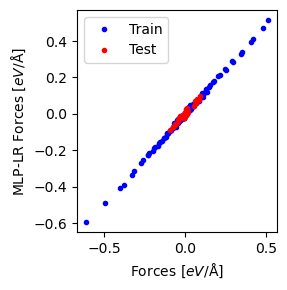

In [58]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, figsize=(3, 3))

ax1.plot(train_f_true[:,0], pred_train['forces'][:,0], '.', color='blue', label='Train')

ax1.plot(test_f_true[:,0], pred_test['forces'][:,0], '.', color='red', label='Test')

ax1.set_xlabel('Forces [$eV/\mathrm{\AA}$]')

ax1.set_ylabel('MLP-LR Forces [$eV/\mathrm{\AA}$]')
ax1.legend()

plt.tight_layout()
plt.show()

In [59]:
def get_property(atoms, info_name):
    return np.array([a.info[info_name] for a in atoms])

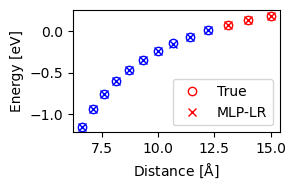

In [60]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(1, figsize=(3, 2))

# Upper panel
ax1.plot(get_property(train_ase_xyz, 'distance'), get_property(train_ase_xyz, 'inter_energy'), 
         'o',color='blue', markerfacecolor='white')
ax1.plot(get_property(test_ase_xyz, 'distance'), get_property(test_ase_xyz, 'inter_energy'), 
         'o',color='red', markerfacecolor='white', label='True')

ax1.plot(get_property(train_ase_xyz, 'distance'), pred_train['energy'], 'x', color='b')
ax1.plot(get_property(test_ase_xyz, 'distance'), pred_test['energy'], 'x', color='r', label='MLP-LR')
#ax1.set_title('Energy')
ax1.set_xlabel('Distance [$\mathrm{\AA}$]')

ax1.set_ylabel('Energy [eV]')
ax1.legend()

plt.tight_layout()
plt.show()